## PROJECT 4: HOUSING DATA


# Executive Summary

## Problem Statement
To classify listings on Zillow.com as either expensive or inexpensive based on bedrooms, bathrooms, type of listing, square footage, and zipcode.

## Data
The information used in this analysis was scraped from Zillow.com and since a large number of listings existed on that website, I was free to drop null values in order to attain a clean dataset. 

The 'type of listing' was the only non-numeric feature included in this project and so I converted it to a series of dummy variables. It may help the reader to understand dummy variables as a series of columns that consists of 1s and 0s. 1, or True, if the unit in question falls under a certain type of listing and 0, or False, if it does not. 

## Modeling
After cleaning the data and standardizing it, I experimented with two modeling techniques; Logistic Regression and K Nearest Neighbors. The metric of concern in this analysis was dollars/square foot. The listings that had more valuable units by area when compared to the median listing were considered expensive and the remaining ones were deemed inexpensive (this is the classification that we will aim to predict).

## Conclusions
When experiments were ran in parallel I found K Nearest Neighbors to yield the greatest accuracy when making predictions about the test data that it had never seen before. 84.7% of the time, my model correctly identified a unit as either an expensive or inexpensive unit based on what it learned from the training data. That is a considerable improvement because without a model, random chance would’ve have only guessed correctly about 50% of the time so the existence of this model improves our ability to predict by more than 30%. 

# Data Exploration: What are we working with

In [10]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model, model_selection, metrics, feature_extraction, neighbors, preprocessing 
import re
df = pd.read_csv("housing.csv")
print(df.head())
print(df.shape)
print(df.columns)    

                                    address                   bed_bath  \
0  360 E Randolph St # 601-602, Chicago, IL  3 bds · 4 ba · 2,700 sqft   
1    8 E Randolph St UNIT 1006, Chicago, IL     1 bd · 1 ba · 850 sqft   
2                                       NaN                        NaN   
3    340 E Randolph St APT 704, Chicago, IL  2 bds · 3 ba · 1,902 sqft   
4  420 E Waterside Dr UNIT 310, Chicago, IL  2 bds · 3 ba · 1,500 sqft   

                                           more_info       price  \
0  http://www.zillow.com/homedetails/360-E-Randol...  $1,299,000   
1  http://www.zillow.com/homedetails/8-E-Randolph...    $324,900   
2                                                NaN         NaN   
3  http://www.zillow.com/homedetails/340-E-Randol...  $1,099,000   
4  http://www.zillow.com/homedetails/420-E-Waters...    $567,770   

           status  zip_code  
0  Condo For Sale     60601  
1  Condo For Sale     60601  
2             NaN     60601  
3  Condo For Sale     6060

In [11]:
print(df.loc[df["address"].isnull()])
print(df.shape)
df.dropna(inplace = True)
df.shape

     address bed_bath more_info price status  zip_code
2        NaN      NaN       NaN   NaN    NaN     60601
30       NaN      NaN       NaN   NaN    NaN     60601
58       NaN      NaN       NaN   NaN    NaN     60601
85       NaN      NaN       NaN   NaN    NaN     60601
112      NaN      NaN       NaN   NaN    NaN     60601
138      NaN      NaN       NaN   NaN    NaN     60602
153      NaN      NaN       NaN   NaN    NaN     60602
168      NaN      NaN       NaN   NaN    NaN     60602
183      NaN      NaN       NaN   NaN    NaN     60602
198      NaN      NaN       NaN   NaN    NaN     60602
213      NaN      NaN       NaN   NaN    NaN     60603
241      NaN      NaN       NaN   NaN    NaN     60603
257      NaN      NaN       NaN   NaN    NaN     60603
285      NaN      NaN       NaN   NaN    NaN     60603
313      NaN      NaN       NaN   NaN    NaN     60603
341      NaN      NaN       NaN   NaN    NaN     60604
354      NaN      NaN       NaN   NaN    NaN     60604
367      N

(4926, 6)

We can clearly see that the above rows serve us no purpose because of the simple fact that a zip code alone does not get us any closer to a valid predictive model about price. Therefore, I am choosing to drop these rows. 

In [12]:
df.loc[df["bed_bath"].isnull()]

,address,bed_bath,more_info,price,status,zip_code


In [13]:
df.loc[df["price"].isnull()]

,address,bed_bath,more_info,price,status,zip_code


The two above cells simply serve as proof that our decision to drop null rows served as a fair first step

In [14]:
print(df["bed_bath"].value_counts())

-- bds · -- ba · -- sqft       135
2 bds · 2 ba · -- sqft         106
1 bd · 1 ba · -- sqft           93
4 bds · 2 ba · -- sqft          81
2 bds · 1 ba · -- sqft          77
2 bds · 2 ba · 1,200 sqft       55
3 bds · 2 ba · -- sqft          55
6 bds · 2 ba · -- sqft          47
Studio · -- ba · -- sqft        46
5 bds · 2 ba · -- sqft          45
2 bds · 1 ba · 1,000 sqft       39
1 bd · 1 ba · 800 sqft          36
2 bds · 2 ba · 1,400 sqft       34
3 bds · 3 ba · -- sqft          33
5 bds · 3 ba · -- sqft          33
1 bd · 1 ba · 850 sqft          30
3 bds · 2 ba · 1,800 sqft       27
2 bds · 2 ba · 1,300 sqft       27
3 bds · 2 ba · 1,600 sqft       27
2 bds · 1 ba · 900 sqft         27
1 bd · 1 ba · 900 sqft          26
3 bds · 2 ba · 1,200 sqft       26
4 bds · 3 ba · -- sqft          25
3 bds · 3 ba · 2,000 sqft       25
2 bds · 1 ba · 800 sqft         23
2 bds · 2 ba · 1,000 sqft       23
3 bds · 2 ba · 1,500 sqft       23
6 bds · 3 ba · -- sqft          22
2 bds · 2 ba · 1,100

We have an alarmingly high number of entries (135) with no bed, bath, or square footage values. These will be of little value to us because those statistics are assumed to be significant when estimating price. Therefore I am choosing to drop those as well

In [15]:
df = df[df["bed_bath"] != '-- bds · -- ba · -- sqft']
df.shape
print(df["bed_bath"].value_counts())

2 bds · 2 ba · -- sqft         106
1 bd · 1 ba · -- sqft           93
4 bds · 2 ba · -- sqft          81
2 bds · 1 ba · -- sqft          77
2 bds · 2 ba · 1,200 sqft       55
3 bds · 2 ba · -- sqft          55
6 bds · 2 ba · -- sqft          47
Studio · -- ba · -- sqft        46
5 bds · 2 ba · -- sqft          45
2 bds · 1 ba · 1,000 sqft       39
1 bd · 1 ba · 800 sqft          36
2 bds · 2 ba · 1,400 sqft       34
3 bds · 3 ba · -- sqft          33
5 bds · 3 ba · -- sqft          33
1 bd · 1 ba · 850 sqft          30
3 bds · 2 ba · 1,800 sqft       27
2 bds · 1 ba · 900 sqft         27
3 bds · 2 ba · 1,600 sqft       27
2 bds · 2 ba · 1,300 sqft       27
1 bd · 1 ba · 900 sqft          26
3 bds · 2 ba · 1,200 sqft       26
3 bds · 3 ba · 2,000 sqft       25
4 bds · 3 ba · -- sqft          25
3 bds · 2 ba · 1,500 sqft       23
2 bds · 1 ba · 800 sqft         23
2 bds · 2 ba · 1,000 sqft       23
6 bds · 3 ba · -- sqft          22
2 bds · 2 ba · 1,100 sqft       22
1 bd · 1 ba · 1,000 

In [16]:
print(df["status"].value_counts())
df.loc[df["status"] == "Coming Soon"]
#these listings have a substantial amount of data
df.loc[df["status"] == "Co-op For Sale"]
#these listings have a substantial amount of data
df.loc[df["status"] == "Make Me Move®"]
#good data points
print(df.loc[df["status"] == "New Construction"])
#useful data

Condo For Sale        1943
House For Sale        1331
Apartment For Sale     466
Foreclosure            200
Auction                196
For Sale by Owner      166
New Construction       143
Lot/Land For Sale      141
Townhouse For Sale     109
Make Me Move®           67
Co-op For Sale          20
Coming Soon              9
Name: status, dtype: int64
                                                address  \
28                  363 E Wacker Dr # 5505, Chicago, IL   
32                  363 E Wacker Dr # 1902, Chicago, IL   
35                  363 E Wacker Dr # 1303, Chicago, IL   
36                  363 E Wacker Dr # 6505, Chicago, IL   
37                  363 E Wacker Dr # 2601, Chicago, IL   
38                  363 E Wacker Dr # 2406, Chicago, IL   
39                  363 E Wacker Dr # 5603, Chicago, IL   
47                  363 E Wacker Dr # 5405, Chicago, IL   
48                  363 E Wacker Dr # 3806, Chicago, IL   
49                  363 E Wacker Dr # 2306, Chicago, IL   


We can see that regardless of Status, valid data appears to be available for each category so we will attempt to extract dummy variables for each type of listing

In [17]:
dummies = pd.get_dummies(df["status"])
df = pd.concat([df, dummies], axis = 1)
df.head()

,address,bed_bath,more_info,price,status,zip_code,Apartment For Sale,Auction,Co-op For Sale,Coming Soon,Condo For Sale,For Sale by Owner,Foreclosure,House For Sale,Lot/Land For Sale,Make Me Move®,New Construction,Townhouse For Sale
0,"360 E Randolph St # 601-602, Chicago, IL","3 bds · 4 ba · 2,700 sqft",http://www.zillow.com/homedetails/360-E-Randol...,"$1,299,000",Condo For Sale,60601,0,0,0,0,1,0,0,0,0,0,0,0
1,"8 E Randolph St UNIT 1006, Chicago, IL",1 bd · 1 ba · 850 sqft,http://www.zillow.com/homedetails/8-E-Randolph...,"$324,900",Condo For Sale,60601,0,0,0,0,1,0,0,0,0,0,0,0
3,"340 E Randolph St APT 704, Chicago, IL","2 bds · 3 ba · 1,902 sqft",http://www.zillow.com/homedetails/340-E-Randol...,"$1,099,000",Condo For Sale,60601,0,0,0,0,1,0,0,0,0,0,0,0
4,"420 E Waterside Dr UNIT 310, Chicago, IL","2 bds · 3 ba · 1,500 sqft",http://www.zillow.com/homedetails/420-E-Waters...,"$567,770",Condo For Sale,60601,0,0,0,0,1,0,0,0,0,0,0,0
5,"155 N Harbor Dr # 1212-13, Chicago, IL","3 bds · 3 ba · 2,367 sqft",http://www.zillow.com/homedetails/155-N-Harbor...,"$1,350,000",Condo For Sale,60601,0,0,0,0,1,0,0,0,0,0,0,0


We can see that the price column is of the object type and in order to do more rigorous analysis I would like to convert those values to floats

In [18]:
def money_floater(obj_str):
    return_str = obj_str.replace("$" , "")
    return_str = return_str.replace(" " , "")
    return_str = return_str.replace(",", "")
    return_str = return_str.replace("+", "")
    if "M" in return_str:
        return_str = return_str.replace("M", "")
        fl = float(return_str)
        return fl * 1000000
    elif "K" in return_str:
        return_str = return_str.replace("K", "")
        fl = float(return_str)
        return fl * 1000
    else:
        return float(return_str)
df["price"] = df["price"].apply(money_floater)
df.head()

,address,bed_bath,more_info,price,status,zip_code,Apartment For Sale,Auction,Co-op For Sale,Coming Soon,Condo For Sale,For Sale by Owner,Foreclosure,House For Sale,Lot/Land For Sale,Make Me Move®,New Construction,Townhouse For Sale
0,"360 E Randolph St # 601-602, Chicago, IL","3 bds · 4 ba · 2,700 sqft",http://www.zillow.com/homedetails/360-E-Randol...,1299000.0,Condo For Sale,60601,0,0,0,0,1,0,0,0,0,0,0,0
1,"8 E Randolph St UNIT 1006, Chicago, IL",1 bd · 1 ba · 850 sqft,http://www.zillow.com/homedetails/8-E-Randolph...,324900.0,Condo For Sale,60601,0,0,0,0,1,0,0,0,0,0,0,0
3,"340 E Randolph St APT 704, Chicago, IL","2 bds · 3 ba · 1,902 sqft",http://www.zillow.com/homedetails/340-E-Randol...,1099000.0,Condo For Sale,60601,0,0,0,0,1,0,0,0,0,0,0,0
4,"420 E Waterside Dr UNIT 310, Chicago, IL","2 bds · 3 ba · 1,500 sqft",http://www.zillow.com/homedetails/420-E-Waters...,567770.0,Condo For Sale,60601,0,0,0,0,1,0,0,0,0,0,0,0
5,"155 N Harbor Dr # 1212-13, Chicago, IL","3 bds · 3 ba · 2,367 sqft",http://www.zillow.com/homedetails/155-N-Harbor...,1350000.0,Condo For Sale,60601,0,0,0,0,1,0,0,0,0,0,0,0


Now I want to extract the bed, bath and square footage values and place them in their own respective columns

In [19]:
def bedder(row):
    if "bd" in row:
        if row.split(" ")[0] != "--":
            bedrooms = row.split(" ")[0]
            return int(bedrooms)
        else:
            bedrooms = 0
            return int(bedrooms)
    else:
        bedrooms = 0
        return int(bedrooms)
df["bedrooms"] = df["bed_bath"].apply(bedder)
df.head()

,address,bed_bath,more_info,price,status,zip_code,Apartment For Sale,Auction,Co-op For Sale,Coming Soon,Condo For Sale,For Sale by Owner,Foreclosure,House For Sale,Lot/Land For Sale,Make Me Move®,New Construction,Townhouse For Sale,bedrooms
0,"360 E Randolph St # 601-602, Chicago, IL","3 bds · 4 ba · 2,700 sqft",http://www.zillow.com/homedetails/360-E-Randol...,1299000.0,Condo For Sale,60601,0,0,0,0,1,0,0,0,0,0,0,0,3
1,"8 E Randolph St UNIT 1006, Chicago, IL",1 bd · 1 ba · 850 sqft,http://www.zillow.com/homedetails/8-E-Randolph...,324900.0,Condo For Sale,60601,0,0,0,0,1,0,0,0,0,0,0,0,1
3,"340 E Randolph St APT 704, Chicago, IL","2 bds · 3 ba · 1,902 sqft",http://www.zillow.com/homedetails/340-E-Randol...,1099000.0,Condo For Sale,60601,0,0,0,0,1,0,0,0,0,0,0,0,2
4,"420 E Waterside Dr UNIT 310, Chicago, IL","2 bds · 3 ba · 1,500 sqft",http://www.zillow.com/homedetails/420-E-Waters...,567770.0,Condo For Sale,60601,0,0,0,0,1,0,0,0,0,0,0,0,2
5,"155 N Harbor Dr # 1212-13, Chicago, IL","3 bds · 3 ba · 2,367 sqft",http://www.zillow.com/homedetails/155-N-Harbor...,1350000.0,Condo For Sale,60601,0,0,0,0,1,0,0,0,0,0,0,0,3


In [20]:
def square_footer(row):
    if "sqft" in row:
        if row.split(" ")[-2] != "sqft":
            sqft = row.split(" ")[-2]
            sqft = sqft.replace(",", "")
            sqft = sqft.replace("+", "")
            sqft = sqft.replace("--", "0")
            return float(sqft)
        else:
            sqft = row.split(" ")[-3]
            sqft = sqft.replace(",", "")
            sqft = sqft.replace("+", "")
            sqft = sqft.replace("--", "0")
            return float(sqft)
    else:
        sqft = 0
df["sqft"] = df["bed_bath"].apply(square_footer)
df.head()

,address,bed_bath,more_info,price,status,zip_code,Apartment For Sale,Auction,Co-op For Sale,Coming Soon,Condo For Sale,For Sale by Owner,Foreclosure,House For Sale,Lot/Land For Sale,Make Me Move®,New Construction,Townhouse For Sale,bedrooms,sqft
0,"360 E Randolph St # 601-602, Chicago, IL","3 bds · 4 ba · 2,700 sqft",http://www.zillow.com/homedetails/360-E-Randol...,1299000.0,Condo For Sale,60601,0,0,0,0,1,0,0,0,0,0,0,0,3,2700.0
1,"8 E Randolph St UNIT 1006, Chicago, IL",1 bd · 1 ba · 850 sqft,http://www.zillow.com/homedetails/8-E-Randolph...,324900.0,Condo For Sale,60601,0,0,0,0,1,0,0,0,0,0,0,0,1,850.0
3,"340 E Randolph St APT 704, Chicago, IL","2 bds · 3 ba · 1,902 sqft",http://www.zillow.com/homedetails/340-E-Randol...,1099000.0,Condo For Sale,60601,0,0,0,0,1,0,0,0,0,0,0,0,2,1902.0
4,"420 E Waterside Dr UNIT 310, Chicago, IL","2 bds · 3 ba · 1,500 sqft",http://www.zillow.com/homedetails/420-E-Waters...,567770.0,Condo For Sale,60601,0,0,0,0,1,0,0,0,0,0,0,0,2,1500.0
5,"155 N Harbor Dr # 1212-13, Chicago, IL","3 bds · 3 ba · 2,367 sqft",http://www.zillow.com/homedetails/155-N-Harbor...,1350000.0,Condo For Sale,60601,0,0,0,0,1,0,0,0,0,0,0,0,3,2367.0


In [21]:
def bather(row):
    if "ba" in row:
        if row.split(" ")[3] != "ba":
            bathrooms = row.split(" ")[3]
            bathrooms = bathrooms.replace("--", "0")
            return float(bathrooms)
        else:
            bathrooms = row.split(" ")[2]
            bathrooms = bathrooms.replace("--", "0")
            return float(bathrooms)
    else:
        bathrooms = 0
        return bathrooms
df["bathrooms"] = df["bed_bath"].apply(bather)
df.head()

,address,bed_bath,more_info,price,status,zip_code,Apartment For Sale,Auction,Co-op For Sale,Coming Soon,...,For Sale by Owner,Foreclosure,House For Sale,Lot/Land For Sale,Make Me Move®,New Construction,Townhouse For Sale,bedrooms,sqft,bathrooms
0,"360 E Randolph St # 601-602, Chicago, IL","3 bds · 4 ba · 2,700 sqft",http://www.zillow.com/homedetails/360-E-Randol...,1299000.0,Condo For Sale,60601,0,0,0,0,...,0,0,0,0,0,0,0,3,2700.0,4.0
1,"8 E Randolph St UNIT 1006, Chicago, IL",1 bd · 1 ba · 850 sqft,http://www.zillow.com/homedetails/8-E-Randolph...,324900.0,Condo For Sale,60601,0,0,0,0,...,0,0,0,0,0,0,0,1,850.0,1.0
3,"340 E Randolph St APT 704, Chicago, IL","2 bds · 3 ba · 1,902 sqft",http://www.zillow.com/homedetails/340-E-Randol...,1099000.0,Condo For Sale,60601,0,0,0,0,...,0,0,0,0,0,0,0,2,1902.0,3.0
4,"420 E Waterside Dr UNIT 310, Chicago, IL","2 bds · 3 ba · 1,500 sqft",http://www.zillow.com/homedetails/420-E-Waters...,567770.0,Condo For Sale,60601,0,0,0,0,...,0,0,0,0,0,0,0,2,1500.0,3.0
5,"155 N Harbor Dr # 1212-13, Chicago, IL","3 bds · 3 ba · 2,367 sqft",http://www.zillow.com/homedetails/155-N-Harbor...,1350000.0,Condo For Sale,60601,0,0,0,0,...,0,0,0,0,0,0,0,3,2367.0,3.0


Now I would like to clean up our dataframe a bit and remove values that I don't use

In [22]:
df = df.drop(['bed_bath', 'more_info', 'status'], axis = 1)

In [23]:
df.head()

,address,price,zip_code,Apartment For Sale,Auction,Co-op For Sale,Coming Soon,Condo For Sale,For Sale by Owner,Foreclosure,House For Sale,Lot/Land For Sale,Make Me Move®,New Construction,Townhouse For Sale,bedrooms,sqft,bathrooms
0,"360 E Randolph St # 601-602, Chicago, IL",1299000.0,60601,0,0,0,0,1,0,0,0,0,0,0,0,3,2700.0,4.0
1,"8 E Randolph St UNIT 1006, Chicago, IL",324900.0,60601,0,0,0,0,1,0,0,0,0,0,0,0,1,850.0,1.0
3,"340 E Randolph St APT 704, Chicago, IL",1099000.0,60601,0,0,0,0,1,0,0,0,0,0,0,0,2,1902.0,3.0
4,"420 E Waterside Dr UNIT 310, Chicago, IL",567770.0,60601,0,0,0,0,1,0,0,0,0,0,0,0,2,1500.0,3.0
5,"155 N Harbor Dr # 1212-13, Chicago, IL",1350000.0,60601,0,0,0,0,1,0,0,0,0,0,0,0,3,2367.0,3.0


In [24]:
print(df["sqft"].value_counts())
df.shape

0.0       941
1200.0    135
1000.0    107
900.0      77
1600.0     75
1400.0     74
800.0      70
1800.0     70
1100.0     68
1500.0     67
2000.0     63
1300.0     61
2200.0     44
850.0      41
1700.0     34
1250.0     32
1350.0     31
2300.0     31
3000.0     31
2400.0     30
700.0      29
1.0        29
2800.0     28
1900.0     23
750.0      22
2100.0     20
2600.0     19
3049.0     19
4000.0     19
1150.0     19
         ... 
7640.0      1
977.0       1
3602.0      1
2125.0      1
1252.0      1
1209.0      1
4791.0      1
1243.0      1
1570.0      1
999.0       1
1962.0      1
907.0       1
1459.0      1
6600.0      1
2292.0      1
5797.0      1
5231.0      1
4058.0      1
1211.0      1
2313.0      1
1652.0      1
510.0       1
1516.0      1
885.0       1
1432.0      1
1736.0      1
1276.0      1
1384.0      1
1011.0      1
2678.0      1
Name: sqft, dtype: int64


(4791, 18)

In [25]:
df.corr()['price']

price                 1.000000
zip_code             -0.180443
Apartment For Sale   -0.068685
Auction              -0.084670
Co-op For Sale       -0.008187
Coming Soon           0.011162
Condo For Sale        0.047979
For Sale by Owner    -0.026297
Foreclosure          -0.096430
House For Sale        0.024185
Lot/Land For Sale    -0.051823
Make Me Move®         0.019996
New Construction      0.188101
Townhouse For Sale    0.008558
bedrooms              0.136432
sqft                  0.397743
bathrooms             0.474562
Name: price, dtype: float64

So we have a bit of a problem. Of the 4791 entries that we have gathered and cleaned, nearly 1000 of them lack any square footage information and we can see that of the variables collected, square footage has the second strongest correlation with overall price. For this reason, I am choosing to drop the units without sqft values.

In [26]:
df = df[df["sqft"] != 0.0]
df.shape

(3850, 18)

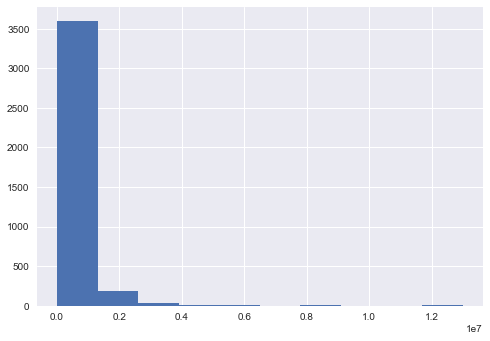

In [27]:
plt.hist(df["price"])
plt.show()

There are a number of very expensive units skewing our data right. The overwhelming majority of listings are priced between 0 and one million dollars.

In [28]:
print(df.groupby('zip_code')['price'].mean().sort_values(ascending = False))

zip_code
60602    1.678846e+06
60610    1.623879e+06
60614    1.273890e+06
60601    1.195968e+06
60611    1.039014e+06
60603    9.308486e+05
60622    8.169953e+05
60606    7.851125e+05
60657    7.363463e+05
60607    7.332582e+05
60604    7.030000e+05
60618    6.929516e+05
60647    6.413441e+05
60646    6.230886e+05
60613    5.958090e+05
60605    5.765992e+05
60616    4.908412e+05
60661    4.534784e+05
60625    4.528867e+05
60631    4.198137e+05
60630    3.867105e+05
60645    3.863484e+05
60641    3.824143e+05
60640    3.647544e+05
60653    3.395305e+05
60660    3.262750e+05
60615    3.166315e+05
60656    2.994283e+05
60634    2.979823e+05
60659    2.963021e+05
60608    2.929043e+05
60637    2.747198e+05
60626    2.616683e+05
60655    2.548635e+05
60612    2.399061e+05
60638    2.361284e+05
60632    2.334605e+05
60635    2.235368e+05
60639    2.235368e+05
60643    2.134362e+05
60652    1.923163e+05
60609    1.694200e+05
60629    1.658603e+05
60649    1.336073e+05
60651    1.297536e+05
6

We see a sizable gap in mean(price) amongst zip codes so I assume zip code will be a significant variable to include in future models

from IPython.display import Image
Image("http://chicagoparalegalservices.com/images/chicago-zip-code-map2-1061x1100.png")
![title](http://chicagoparalegalservices.com/images/chicago-zip-code-map2-1061x1100.png)

In [29]:
df.isnull().sum()

address                0
price                  0
zip_code               0
Apartment For Sale     0
Auction                0
Co-op For Sale         0
Coming Soon            0
Condo For Sale         0
For Sale by Owner      0
Foreclosure            0
House For Sale         0
Lot/Land For Sale      0
Make Me Move®          0
New Construction       0
Townhouse For Sale     0
bedrooms               0
sqft                  10
bathrooms              0
dtype: int64

In [30]:
df = df.dropna(subset = ['sqft'], axis = 0)
df.isnull().sum()

address               0
price                 0
zip_code              0
Apartment For Sale    0
Auction               0
Co-op For Sale        0
Coming Soon           0
Condo For Sale        0
For Sale by Owner     0
Foreclosure           0
House For Sale        0
Lot/Land For Sale     0
Make Me Move®         0
New Construction      0
Townhouse For Sale    0
bedrooms              0
sqft                  0
bathrooms             0
dtype: int64

Now that we have successfully cleaned our data, we need to choose a metric that differentiates expensive listings from inexpensive listings. With the information that we have available, I choose to use the metric of price per square foot which I can solve for now 

In [31]:
df["price_per_sqft"] = df['price'] / df['sqft']
df.describe()

,price,zip_code,Apartment For Sale,Auction,Co-op For Sale,Coming Soon,Condo For Sale,For Sale by Owner,Foreclosure,House For Sale,Lot/Land For Sale,Make Me Move®,New Construction,Townhouse For Sale,bedrooms,sqft,bathrooms,price_per_sqft
count,3.840000e+03,3840.000000,3840.000000,3840.00000,3840.000000,3840.000000,3840.000000,3840.000000,3840.000000,3840.000000,3840.000000,3840.000000,3840.000000,3840.000000,3840.000000,3840.000000,3840.000000,3.840000e+03
mean,5.021378e+05,60629.453906,0.027604,0.05026,0.004687,0.001823,0.419010,0.036198,0.041406,0.313281,0.031250,0.016927,0.033333,0.024219,2.866146,1864.296875,2.192188,3.051766e+03
std,8.342784e+05,26.117632,0.163857,0.21851,0.068314,0.042662,0.493461,0.186807,0.199254,0.463888,0.174015,0.129015,0.179529,0.153748,1.596036,1728.367363,1.214189,3.840751e+04
min,1.000000e+03,60601.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.766160e-01
25%,1.549000e+05,60611.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1079.500000,1.000000,1.149500e+02
50%,2.977500e+05,60626.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,1440.000000,2.000000,2.124275e+02
75%,5.300000e+05,60644.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2200.000000,3.000000,3.332216e+02
max,1.300000e+07,60827.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,75000.000000,11.000000,1.149000e+06


The cutoff will be at the 50 percentile which as can be seen above, is $212.42 per square foot

In [32]:
def price_categorizer(row):
    if row >= 212.4275:
        expensive_home = 1
        return expensive_home
    else:
        expensive_home = 0
        return expensive_home
df["expensive"] = df["price_per_sqft"].apply(price_categorizer)
df["expensive"].value_counts()

1    1920
0    1920
Name: expensive, dtype: int64

# Data Modeling

Before leveraging the K Nearest Neighbors modeling technique, we have to standardize our data in order to ensure that all features operate on the same scale and have a uniform effect on our predictions (regardless of their units). I also would like to take a look at the correlations between features and targets

In [33]:
print(df.columns)
print(df.corr()['price'])
print(df.corr()["expensive"])

Index(['address', 'price', 'zip_code', 'Apartment For Sale', 'Auction',
       'Co-op For Sale', 'Coming Soon', 'Condo For Sale', 'For Sale by Owner',
       'Foreclosure', 'House For Sale', 'Lot/Land For Sale', 'Make Me Move®',
       'New Construction', 'Townhouse For Sale', 'bedrooms', 'sqft',
       'bathrooms', 'price_per_sqft', 'expensive'],
      dtype='object')
price                 1.000000
zip_code             -0.193398
Apartment For Sale   -0.029650
Auction              -0.097935
Co-op For Sale       -0.011180
Coming Soon           0.014189
Condo For Sale        0.063036
For Sale by Owner    -0.023005
Foreclosure          -0.097541
House For Sale       -0.015189
Lot/Land For Sale    -0.076666
Make Me Move®         0.018172
New Construction      0.201958
Townhouse For Sale    0.005390
bedrooms              0.202822
sqft                  0.432217
bathrooms             0.545626
price_per_sqft        0.006176
expensive             0.366812
Name: price, dtype: float64
price      

In [34]:
scaler = preprocessing.StandardScaler()
df_stand = scaler.fit_transform(df[['price', 'zip_code', 'Apartment For Sale', 'Auction',
       'Co-op For Sale', 'Coming Soon', 'Condo For Sale', 'For Sale by Owner',
       'Foreclosure', 'House For Sale', 'Lot/Land For Sale', 'Make Me Move®',
       'New Construction', 'Townhouse For Sale', 'bedrooms', 'sqft',
       'bathrooms', 'price_per_sqft']])
df_stand = pd.DataFrame(df_stand, columns = ['price', 'zip_code', 'Apartment For Sale', 'Auction',
       'Co-op For Sale', 'Coming Soon', 'Condo For Sale', 'For Sale by Owner',
       'Foreclosure', 'House For Sale', 'Lot/Land For Sale', 'Make Me Move®',
       'New Construction', 'Townhouse For Sale', 'bedrooms', 'sqft',
       'bathrooms', 'price_per_sqft'])
df_stand.head()

,price,zip_code,Apartment For Sale,Auction,Co-op For Sale,Coming Soon,Condo For Sale,For Sale by Owner,Foreclosure,House For Sale,Lot/Land For Sale,Make Me Move®,New Construction,Townhouse For Sale,bedrooms,sqft,bathrooms,price_per_sqft
0,0.955276,-1.089594,-0.168487,-0.230044,-0.068626,-0.042735,1.177529,-0.193797,-0.207834,-0.675426,-0.179605,-0.131219,-0.185695,-0.157543,0.083878,0.483585,1.489099,-0.066940
1,-0.212472,-1.089594,-0.168487,-0.230044,-0.068626,-0.042735,1.177529,-0.193797,-0.207834,-0.675426,-0.179605,-0.131219,-0.185695,-0.157543,-1.169390,-0.586929,-0.982007,-0.069514
2,0.715517,-1.089594,-0.168487,-0.230044,-0.068626,-0.042735,1.177529,-0.193797,-0.207834,-0.675426,-0.179605,-0.131219,-0.185695,-0.157543,-0.542756,0.021817,0.665397,-0.064422
3,0.078680,-1.089594,-0.168487,-0.230044,-0.068626,-0.042735,1.177529,-0.193797,-0.207834,-0.675426,-0.179605,-0.131219,-0.185695,-0.157543,-0.542756,-0.210803,0.665397,-0.069611
4,1.016414,-1.089594,-0.168487,-0.230044,-0.068626,-0.042735,1.177529,-0.193797,-0.207834,-0.675426,-0.179605,-0.131219,-0.185695,-0.157543,0.083878,0.290892,0.665397,-0.064616


I would like to set our test data aside before running any models in an attempt to stay organized

In [35]:
y = df['expensive']
df = df.drop('expensive', axis = 1)
x_train, x_test, y_train, y_test = model_selection.train_test_split(df_stand, y, test_size = 0.25, random_state = 17)

In [36]:
def knn_optimizer(x, y):
    knn = neighbors.KNeighborsClassifier()
    grid = model_selection.GridSearchCV(knn, param_grid = {'n_neighbors': [3, 4, 5, 6, 7, 8, 9, 10], 
                                          'weights': ['uniform', 'distance']}, verbose = 1)
    grid.fit(x, y)
    print("Highest mean accuracy: ", grid.best_score_)
    print("N_neighbors and weights that yield best score: ", grid.best_params_)
    knn_best_fit = neighbors.KNeighborsClassifier(n_neighbors = grid.best_params_['n_neighbors'], 
                                                  weights = grid.best_params_['weights'])
    knn_best_fit.fit(x, y)
    predictions = knn_best_fit.predict(x)
    confuse = metrics.confusion_matrix(y, predictions)
    print("Resulting Confusion Matrix\n" , confuse)
    print("Classification Report\n", metrics.classification_report(y, predictions))


In [37]:
xs = x_train[['zip_code', 'bedrooms', 'bathrooms']]
print(xs.shape)
print(y_train.shape)
knn_optimizer(xs, y_train)

(2880, 3)
(2880,)
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Highest mean accuracy:  0.852083333333
N_neighbors and weights that yield best score:  {'n_neighbors': 9, 'weights': 'distance'}
Resulting Confusion Matrix
 [[1354   81]
 [ 140 1305]]
Classification Report
              precision    recall  f1-score   support

          0       0.91      0.94      0.92      1435
          1       0.94      0.90      0.92      1445

avg / total       0.92      0.92      0.92      2880



[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:    0.9s finished


We see that our first model scored relatively well even though I only included the absolute bare essentials of a predictive model (i.e. beds, baths and zip). I would like to test a couple of other combinations of variables but at first glance, I hypothesize that we have overfit our model or erred at some point along the way. This could have happened because of the fact that we leveraged a large n_neighbors value and I set weights = distance which could have given too much influence to a small number of data points that happened to be very close to the input training data. 

I would like to test the effects of including a number of our dummy variables because I know from experience that foreclosed buidlings and auctions are typically less expensive (AKA selling in distress) and Condos and Houses are on average more expensive 

In [38]:
xs = x_train[['zip_code', 'bedrooms', 'bathrooms', 
              'Auction', 'Condo For Sale', 'Foreclosure', 
              'House For Sale', 'Lot/Land For Sale']]
knn_optimizer(xs, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Highest mean accuracy:  0.844097222222
N_neighbors and weights that yield best score:  {'n_neighbors': 10, 'weights': 'distance'}
Resulting Confusion Matrix
 [[1371   64]
 [  92 1353]]
Classification Report
              precision    recall  f1-score   support

          0       0.94      0.96      0.95      1435
          1       0.95      0.94      0.95      1445

avg / total       0.95      0.95      0.95      2880



[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:    1.6s finished


The results show that our f1-scores increased slightly so I would like to test the effects of including all dummy variables

In [39]:
xs = x_train[['zip_code', 'Apartment For Sale', 'Auction',
       'Co-op For Sale', 'Coming Soon', 'Condo For Sale', 'For Sale by Owner',
       'Foreclosure', 'House For Sale', 'Lot/Land For Sale', 'Make Me Move®',
       'New Construction', 'Townhouse For Sale', 'bedrooms', 'bathrooms']]
knn_optimizer(xs, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:    6.9s finished


Highest mean accuracy:  0.844791666667
N_neighbors and weights that yield best score:  {'n_neighbors': 10, 'weights': 'distance'}
Resulting Confusion Matrix
 [[1374   61]
 [  86 1359]]
Classification Report
              precision    recall  f1-score   support

          0       0.94      0.96      0.95      1435
          1       0.96      0.94      0.95      1445

avg / total       0.95      0.95      0.95      2880



Nearly identical results to our previous experiment. Since the last model was simpler I will go foward with that one and run one last test with the help of K Nearest Neighbors. I would like to see what happens if we include sqft in the set of features. I hypothesize that our results will be invalid because of the inverse relationship between sqft and the target variable (expensive = 1 if price/sqft > 212.42)

In [40]:
xs = x_train[['zip_code', 'bedrooms', 'bathrooms', 
              'Auction', 'Condo For Sale', 'Foreclosure', 
              'House For Sale', 'Lot/Land For Sale', 'sqft']]
knn_optimizer(xs, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Highest mean accuracy:  0.815625
N_neighbors and weights that yield best score:  {'n_neighbors': 7, 'weights': 'distance'}
Resulting Confusion Matrix
 [[1428    7]
 [  16 1429]]
Classification Report
              precision    recall  f1-score   support

          0       0.99      1.00      0.99      1435
          1       1.00      0.99      0.99      1445

avg / total       0.99      0.99      0.99      2880



[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:    2.5s finished


As I worried, our results are too close to perfect to be believable. These variables were collectively exhaustive

So now I would like to run a similar set of experiments with the help of the Logistic Regression predictive model. I will attempt to define a similar funcion to knn_optimizer

In [41]:
def logreg_optimizer(x, y):
    logit = linear_model.LogisticRegression()
    grid = model_selection.GridSearchCV(logit, param_grid = {'penalty': ['l1', 'l2'], 'C': [.001, .01, .1, 1, 10, 100], 
                                                             'fit_intercept': [True, False], 
                                                             'tol': [.0001, .001, .01, .1, 1, 10]}, verbose = 1)
    grid.fit(x, y)
    print("Highest mean accuracy: ", grid.best_score_)
    print("The parameters that yield the greatest score: ", grid.best_params_)
    logit_best_fit = linear_model.LogisticRegression(penalty = grid.best_params_['penalty'], 
                                                  C = grid.best_params_['C'], 
                                                     fit_intercept = grid.best_params_['fit_intercept'],
                                                    tol = grid.best_params_['tol'])
    logit_best_fit.fit(x, y)
    predictions = logit_best_fit.predict(x)
    confuse = metrics.confusion_matrix(y, predictions)
    print("Resulting Confusion Matrix\n" , confuse)
    print("Classification Report\n", metrics.classification_report(y, predictions))

In [42]:
xs = x_train[['zip_code', 'bedrooms', 'bathrooms']]
logreg_optimizer(xs, y_train)

Fitting 3 folds for each of 144 candidates, totalling 432 fits
Highest mean accuracy:  0.721875
The parameters that yield the greatest score:  {'fit_intercept': False, 'penalty': 'l1', 'tol': 0.1, 'C': 0.1}
Resulting Confusion Matrix
 [[1028  407]
 [ 398 1047]]
Classification Report
              precision    recall  f1-score   support

          0       0.72      0.72      0.72      1435
          1       0.72      0.72      0.72      1445

avg / total       0.72      0.72      0.72      2880



[Parallel(n_jobs=1)]: Done 432 out of 432 | elapsed:    2.6s finished


The results of this experiment appear to be more realistic. Possibly because the cross-validation is more vigorous in the logreg_optimizer function than it was in the knn_optimizer. More intense CVs could account for models that are subject to less bias (less over-fit)

Now I would like to include the same dummy variables that I ran through the KNN model

In [43]:
xs = x_train[['zip_code', 'bedrooms', 'bathrooms', 
              'Auction', 'Condo For Sale', 'Foreclosure', 
              'House For Sale', 'Lot/Land For Sale']]
logreg_optimizer(xs, y_train)

Fitting 3 folds for each of 144 candidates, totalling 432 fits
Highest mean accuracy:  0.752083333333
The parameters that yield the greatest score:  {'fit_intercept': True, 'penalty': 'l2', 'tol': 0.1, 'C': 10}
Resulting Confusion Matrix
 [[1054  381]
 [ 326 1119]]
Classification Report
              precision    recall  f1-score   support

          0       0.76      0.73      0.75      1435
          1       0.75      0.77      0.76      1445

avg / total       0.75      0.75      0.75      2880



[Parallel(n_jobs=1)]: Done 432 out of 432 | elapsed:    3.0s finished


We see a very small incresae in f1-scores and so I am curious to see if including the remaining dummy variables lends our model more clarity

In [44]:
xs = x_train[['zip_code', 'Apartment For Sale', 'Auction',
       'Co-op For Sale', 'Coming Soon', 'Condo For Sale', 'For Sale by Owner',
       'Foreclosure', 'House For Sale', 'Lot/Land For Sale', 'Make Me Move®',
       'New Construction', 'Townhouse For Sale', 'bedrooms', 'bathrooms']]
logreg_optimizer(xs, y_train)

Fitting 3 folds for each of 144 candidates, totalling 432 fits
Highest mean accuracy:  0.753472222222
The parameters that yield the greatest score:  {'fit_intercept': True, 'penalty': 'l2', 'tol': 0.1, 'C': 10}
Resulting Confusion Matrix
 [[1056  379]
 [ 321 1124]]
Classification Report
              precision    recall  f1-score   support

          0       0.77      0.74      0.75      1435
          1       0.75      0.78      0.76      1445

avg / total       0.76      0.76      0.76      2880



[Parallel(n_jobs=1)]: Done 432 out of 432 | elapsed:    3.5s finished


Yet again, we find nearly identical results so I choose the simpler of the two log_reg models. 

Now I would like to run the test data through our most accurate models (both knn and logistic regression) and see what kind of results we find

# Model Validation

In [45]:
xs = x_train[['zip_code', 'bedrooms', 'bathrooms', 
              'Auction', 'Condo For Sale', 'Foreclosure', 
              'House For Sale', 'Lot/Land For Sale']]
knn = neighbors.KNeighborsClassifier(n_neighbors = 10, weights = 'distance')
knn.fit(xs, y_train)
xs_test = x_test[['zip_code', 'bedrooms', 'bathrooms', 
              'Auction', 'Condo For Sale', 'Foreclosure', 
              'House For Sale', 'Lot/Land For Sale']]
print("Accuracy Score: ", knn.score(xs_test, y_test))
predictions = knn.predict(xs_test)
confuse = metrics.confusion_matrix(y_test, predictions)
print("Resulting Confusion Matrix\n" , confuse)
print("Classification Report\n", metrics.classification_report(y_test, predictions))

Accuracy Score:  0.846875
Resulting Confusion Matrix
 [[416  69]
 [ 78 397]]
Classification Report
              precision    recall  f1-score   support

          0       0.84      0.86      0.85       485
          1       0.85      0.84      0.84       475

avg / total       0.85      0.85      0.85       960



Although the training data yielded better f1-scores and a slightly better accuracy score, these results are fairly promising. We see that our original model may have been slightly overfit but the fact that n_neighbors is 10 and weights is set to 'distance' did not throw off the test data's results significantly. In fact, I would go so far as to say that these results are indicative of a successful model. Our target variable ('expensive') has as many 0 values as it does 1 values so the fact that we correctly predicted 84.6% of the test data shows that we outperformed random chance by more than 30%

Now I would like to test one of my Logistic Regression models 

In [46]:
xs = x_train[['zip_code', 'bedrooms', 'bathrooms', 
              'Auction', 'Condo For Sale', 'Foreclosure', 
              'House For Sale', 'Lot/Land For Sale']]
logit = linear_model.LogisticRegression(penalty = 'l1', C = 1.0, tol = 0.01, fit_intercept = True)
logit.fit(xs, y_train)
xs_test = x_test[['zip_code', 'bedrooms', 'bathrooms', 
              'Auction', 'Condo For Sale', 'Foreclosure', 
              'House For Sale', 'Lot/Land For Sale']]
print("Accuracy Score: ", logit.score(xs_test, y_test))
predictions = logit.predict(xs_test)
confuse = metrics.confusion_matrix(y_test, predictions)
print("Resulting Confusion Matrix\n" , confuse)
print("Classification Report\n", metrics.classification_report(y_test, predictions))

Accuracy Score:  0.741666666667
Resulting Confusion Matrix
 [[367 118]
 [130 345]]
Classification Report
              precision    recall  f1-score   support

          0       0.74      0.76      0.75       485
          1       0.75      0.73      0.74       475

avg / total       0.74      0.74      0.74       960



Yet again, we found nearly the exact same results as we did with the training data. Our f1-scores and accuracy scores had negligible differences and as a consquence, this data scientist is rather content to find that this model outperformed random chance by 24%

Of the two, I am choosing to use the KNN model because it scored about 10% more accurately than the Logistic Regression model did.

The below cell highlights some code that scraped information from Zillow.

In [1]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
from time import sleep
import requests

df = pd.read_csv("housing.csv")
sites = df.dropna(subset = ["more_info"])
sites = sites["more_info"].tolist()

built_in = []

for site in sites:
	name = requests.get(site)
	soup = BeautifulSoup(name.content, 'lxml')
	year_built = soup.find_all('li')	
	for year in year_built:
		txt_extract = year.text
		if 'Built in' in txt_extract:
			built_in.append(int(txt_extract.split(" ")[2]))
	sleep(2)

print(built_in)


NameError: name 'pd' is not defined